### Imports

In [1]:
import os
os.chdir('../../')

from hydra import initialize, compose
from omegaconf import OmegaConf

import mlflow
import pickle
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

### Load Trained Model

In [2]:
with initialize(version_base=None, config_path='../../conf/'):
    cfg = compose(config_name='config')
cfg = cfg.test
print(cfg)

{'mlflow_dir': 'mlruns', 'mlflow_source_experiment_name': '220805_115357_Q3_sweep_1000trial_random', 'mlflow_run_id': '57efaf413c8d457ebca84d6474b10770', 'test_path': '${split_train_test.test_path}', 'target_var': '${train.target_var}', 'invert_target': '${train.invert_target}', 'mlflow_target_experiment_name': '${train.target_var}_test'}


In [3]:
# Load the trained model
exper = mlflow.get_experiment_by_name(cfg.mlflow_source_experiment_name)
model_loc = f'{cfg.mlflow_dir}/{exper.experiment_id}/{cfg.mlflow_run_id}/artifacts/model/model.pkl'
with open(model_loc, 'rb') as f:
    mdl = pickle.load(f)

## ⚖️ Feature Weights

In [4]:
def get_feat_weights_df(mdl):
    coefs = mdl[-1].coef_.copy().flatten()
    feats = mdl[:-1].get_feature_names_out()
    return pd.DataFrame({
        'feature': [f.split('__')[1] for f in feats],
        'coef': coefs,
        'coef.abs': np.abs(coefs),
        'positive': [c >= 0 for c in coefs]
    })

feat_weights = get_feat_weights_df(mdl)
feat_weights = feat_weights.sort_values('coef')
feat_weights = feat_weights.set_index('feature')

### Words/Features Weighted *Toward* Q2 = 1

In [5]:
feat_weights.head(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
vec_1,-0.161635,0.161635
plans,-0.154257,0.154257
vec_79,-0.151571,0.151571
required,-0.146130,0.146130
vec_45,-0.137969,0.137969
child,-0.133545,0.133545
likely,-0.129863,0.129863
vec_91,-0.128560,0.128560
help,-0.127380,0.127380


### Words/Features Weighted *Against* Q2 = 1

In [6]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
PUNCT,0.149579,0.149579
past,0.150521,0.150521
try,0.155067,0.155067
vec_57,0.156252,0.156252
procedural sedation,0.156660,0.156660
successful,0.161301,0.161301
ensure,0.163056,0.163056
think,0.164103,0.164103
wire,0.172040,0.172040


## ⚖️ ➖ Feature Weights (vector features removed)

In [7]:
feat_weights = feat_weights.reset_index()
feat_weights = feat_weights[~feat_weights['feature'].str.contains('vec_')].set_index('feature')

### Words/Features Weighted *Toward* Q2 = 1

In [8]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
urgent,0.148803,0.148803
PUNCT,0.149579,0.149579
past,0.150521,0.150521
try,0.155067,0.155067
procedural sedation,0.156660,0.156660
successful,0.161301,0.161301
ensure,0.163056,0.163056
think,0.164103,0.164103
wire,0.172040,0.172040


### Words/Features Weighted *Against* Q2 = 1

In [9]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
urgent,0.148803,0.148803
PUNCT,0.149579,0.149579
past,0.150521,0.150521
try,0.155067,0.155067
procedural sedation,0.156660,0.156660
successful,0.161301,0.161301
ensure,0.163056,0.163056
think,0.164103,0.164103
wire,0.172040,0.172040


## ☁️ Word Clouds

### All Words

Red means the word is weighted *toward* Q2 = 0

Green means the word is weighted *against* Q2 = 1

In [10]:
def color_func(word, *args, **kwargs):
    if not feat_weights.loc[word, 'positive']: return (60, 186, 72)
    else: return (186, 60, 60)

(-0.5, 799.5, 399.5, -0.5)

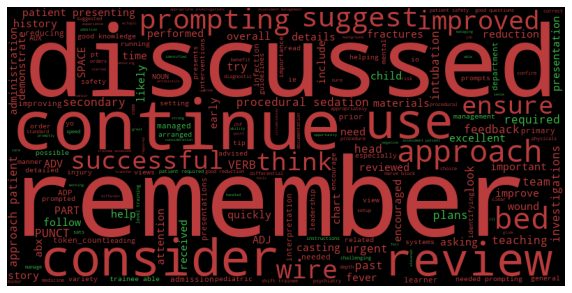

In [11]:
fw_for_wc = feat_weights[['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, color_func=color_func)
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Toward* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

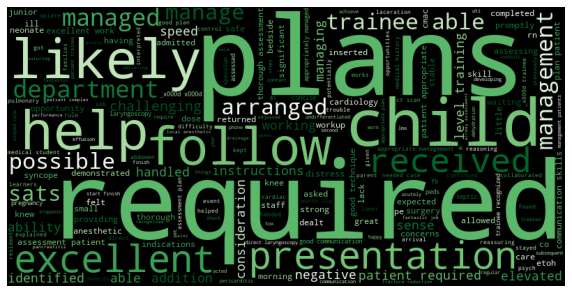

In [12]:
fw_for_wc = feat_weights[feat_weights['coef'] < 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Greens'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Against* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

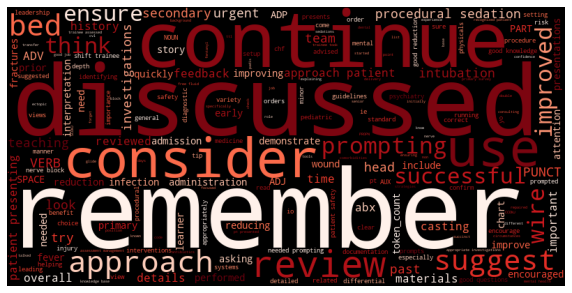

In [13]:
fw_for_wc = feat_weights[feat_weights['coef'] >= 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Reds'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')